In [1]:
def keras_plotter(history):
    import pandas as pd
    import matplotlib.pyplot as plt
    
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2)
    plt.savefig("9_t.jpeg")
    plt.show()
   

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10

(x_train_val, y_train_val), (x_test, y_test) = cifar10.load_data()

from sklearn.model_selection import StratifiedShuffleSplit
strat_split=StratifiedShuffleSplit(n_splits=1,test_size=0.2)
for train_index,test_index in strat_split.split(x_train_val,y_train_val):
    x_train,y_train=x_train_val[train_index],y_train_val[train_index]
    x_val,y_val=x_train_val[test_index],y_train_val[test_index]
    
x_train_val=x_train_val.reshape((50000,3072))
x_train=x_train.reshape((40000,3072))
x_val=x_val.reshape((10000,3072))
x_test=x_test.reshape((10000,3072))

from sklearn.preprocessing import StandardScaler
sta_scal=StandardScaler()
sta_scal.fit(x_train)
x_train_val=sta_scal.transform(x_train_val)
x_train=sta_scal.transform(x_train)
x_val=sta_scal.transform(x_val)
x_test=sta_scal.transform(x_test)


x_train_val=x_train_val.reshape((50000,32, 32, 3))
x_train=x_train.reshape((40000,32, 32, 3))
x_val=x_val.reshape((10000,32, 32, 3))
x_test=x_test.reshape((10000,32, 32, 3))


y_train_val=keras.utils.to_categorical(y_train_val,10)
y_train=keras.utils.to_categorical(y_train,10)
y_val=keras.utils.to_categorical(y_val,10)
y_test=keras.utils.to_categorical(y_test,10)


In [3]:
#HyperParameters Definition
import tensorflow
n_hidden=20
n_units=200
act='elu'
out_act='softmax'
init='he_normal'
init_lr=0.0001
loss_def='categorical_crossentropy'
ep=500
ep_int=50
bat_size=32
max_lr=0.0001
iterations=len(x_train)//bat_size*ep_int
opt=tensorflow.keras.optimizers.Nadam(learning_rate=0.0001)
loss=tensorflow.keras.losses.categorical_crossentropy

In [4]:
#Model Definition
import tensorflow as tf
from tensorflow import keras
#model1=Sequential()
ins=tf.keras.layers.Input(shape=x_train.shape[1:])
layer1=tf.keras.layers.Flatten(input_shape=x_train.shape[1:])(ins)
layer1=tf.keras.layers.Dense(units=n_units,activation=act,kernel_initializer=init)(layer1)
layer1=tf.keras.layers.BatchNormalization()(layer1)
for i in range(n_hidden-1):
    layer1=tf.keras.layers.Dense(units=n_units,activation=act,kernel_initializer=init)(layer1)
    layer1=tf.keras.layers.BatchNormalization()(layer1)
   #if(i%3)==0:
    layer1=tf.keras.layers.Dropout(0.3)(layer1,training=True)
  
outs = tf.keras.layers.Dense(units=10,activation=out_act,kernel_initializer=init)(layer1)
model1=tf.keras.Model(inputs=ins,outputs=outs)
model1.compile(optimizer=opt,loss=loss_def,metrics=['accuracy'])
#model1.add()    

In [5]:
'''
#Model Definition

model1=tensorflow.keras.models.Sequential()
model1.add(tensorflow.keras.layers.Flatten(input_shape=x_train.shape[1:]))

for i in range(n_hidden):
    model1.add(tensorflow.keras.layers.Dense(units=n_units,activation=act,kernel_initializer=init,kernel_regularizer=keras.regularizers.l2(0.01)))

model1.add(tensorflow.keras.layers.Dense(units=10,activation=out_act,kernel_initializer=init,kernel_regularizer=keras.regularizers.l2(0.01)))   
model1.compile(optimizer=opt,loss=loss_def,metrics=['accuracy'])
'''

"\n#Model Definition\n\nmodel1=tensorflow.keras.models.Sequential()\nmodel1.add(tensorflow.keras.layers.Flatten(input_shape=x_train.shape[1:]))\n\nfor i in range(n_hidden):\n    model1.add(tensorflow.keras.layers.Dense(units=n_units,activation=act,kernel_initializer=init,kernel_regularizer=keras.regularizers.l2(0.01)))\n\nmodel1.add(tensorflow.keras.layers.Dense(units=10,activation=out_act,kernel_initializer=init,kernel_regularizer=keras.regularizers.l2(0.01)))   \nmodel1.compile(optimizer=opt,loss=loss_def,metrics=['accuracy'])\n"

Train on 40000 samples
40000/40000 [==============================] - 34s 860us/sample - loss: 9854.2688 - accuracy: 0.1125


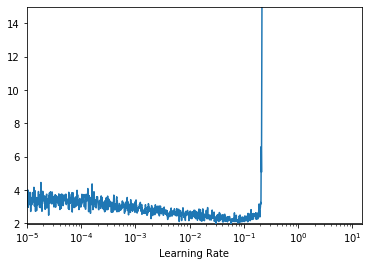

In [6]:
import tensorflow as tf
from tensorflow import keras
model2=tf.keras.models.clone_model(model1)
model2.compile(optimizer=opt,loss=loss_def,metrics=['accuracy'])
K=tf.keras.backend

class explr(keras.callbacks.Callback):
    def __init__(self,factor):
        self.factor=factor
        self.rates=[]
        self.losses=[]
    
    def on_batch_end(self,batch,logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs['loss'])
        K.set_value(self.model.optimizer.lr,self.model.optimizer.lr*self.factor)
    

def lr_finder(model,x,y,epochs=1,batch_size=32,min_rate=1e-5,max_rate=10):
    import numpy as np
    init_w=model.get_weights()
    init_lr=K.get_value(model.optimizer.lr)
    iterations=len(x)//batch_size*epochs
    factor=np.exp(np.log(max_rate/min_rate)/iterations)
    K.set_value(model.optimizer.lr,min_rate)
   
    
    exp_lr=explr(factor)
    model.fit(x,y,epochs=epochs,batch_size=batch_size,callbacks=[exp_lr])
    model.set_weights(init_w)
    K.set_value(model.optimizer.lr,init_lr)
    rates=exp_lr.rates
    losses=exp_lr.losses
   
    
    import matplotlib.pyplot as plt
    plt.plot(rates,losses)
    plt.gca().set_xscale("log")
    plt.hlines(min(losses),min(rates),max(rates))
    plt.axis([min(rates),max(rates),min(losses),15])
    plt.xlabel("Learning Rate")
    

lr_finder(model2,x_train,y_train,epochs=1,batch_size=32,min_rate=1e-5,max_rate=15)

In [7]:
import tensorflow as tf
from tensorflow import keras
K=tf.keras.backend
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self,iterations,max_lr,start_lr=None,last_iterations=None,last_lr=None):
        self.iterations=iterations
        self.max_lr=max_lr
        self.start_lr=start_lr or max_lr/10
        self.last_iterations=last_iterations or iterations//10+1
        self.half_iteration=(iterations-self.last_iterations)//2
        self.last_lr=last_lr or self.start_lr/1000
        self.iteration=0
     
    def interpolate(self,iter1,iter2,rate1,rate2):
        temp1=((rate2-rate1)/(iter2-iter1))*(self.iteration-iter1)
        temp2=rate1+temp1
        return temp2
    
    def on_batch_begin(self,batch,logs):
        
        if self.iteration<self.half_iteration:
            rate=self.interpolate(0,self.half_iteration,self.start_lr,self.max_lr)
        
        elif self.iteration <2*self.half_iteration:
            
            rate=self.interpolate(self.half_iteration,2*self.half_iteration,self.max_lr,self.start_lr)

            
        else:
            rate=self.interpolate(2*self.half_iteration,self.iterations,self.start_lr,self.last_lr)
            rate=max(rate,self.last_lr)
            
        
        self.iteration+=1
        K.set_value(self.model.optimizer.lr,rate)
        
onec=OneCycleScheduler(iterations=iterations,max_lr=max_lr)        

In [8]:
import tensorflow as tf
class custom_escb(tf.keras.callbacks.EarlyStopping):
    def __init__(self,monitor='val_loss', min_delta=0, patience=10, verbose=2, mode='auto',baseline=None, restore_best_weights=True,start_epoch=50):
        super(custom_escb,self).__init__()
        self.monitor=monitor
        self.patience=patience
        self.verbose=verbose
        self.start_epoch=start_epoch
                
    def on_epoch_end(self,epoch,logs=None):
        if(epoch>self.start_epoch):
            super().on_epoch_end(epoch,logs)
cescb=custom_escb()       

In [9]:
escb=tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=10,verbose=2,restore_best_weights=True)
history=model1.fit(initial_epoch=0,x=x_train,y=y_train,epochs=ep,validation_data=(x_val,y_val),batch_size=32,callbacks=[onec,cescb])#

Train on 40000 samples, validate on 10000 samples
Epoch 1/500
40000/40000 [==============================] - 35s 872us/sample - loss: 3.2253 - accuracy: 0.0988 - val_loss: 3.2134 - val_accuracy: 0.0967
Epoch 2/500
40000/40000 [==============================] - 30s 758us/sample - loss: 3.0702 - accuracy: 0.0987 - val_loss: 3.0653 - val_accuracy: 0.1005
Epoch 3/500
40000/40000 [==============================] - 29s 713us/sample - loss: 2.9396 - accuracy: 0.1019 - val_loss: 2.9544 - val_accuracy: 0.0978
Epoch 4/500
40000/40000 [==============================] - 26s 661us/sample - loss: 2.8527 - accuracy: 0.1003 - val_loss: 2.8440 - val_accuracy: 0.1031
Epoch 5/500
40000/40000 [==============================] - 26s 662us/sample - loss: 2.7770 - accuracy: 0.1009 - val_loss: 2.7747 - val_accuracy: 0.1013
Epoch 6/500
40000/40000 [==============================] - 27s 668us/sample - loss: 2.7125 - accuracy: 0.1020 - val_loss: 2.7152 - val_accuracy: 0.1018
Epoch 7/500
40000/40000 [=============

40000/40000 [==============================] - 41s 1ms/sample - loss: 1.5334 - accuracy: 0.4392 - val_loss: 1.6011 - val_accuracy: 0.4178
Epoch 55/500
40000/40000 [==============================] - 40s 998us/sample - loss: 1.5311 - accuracy: 0.4409 - val_loss: 1.5911 - val_accuracy: 0.4230
Epoch 56/500
40000/40000 [==============================] - 42s 1ms/sample - loss: 1.5360 - accuracy: 0.4385 - val_loss: 1.5994 - val_accuracy: 0.4268
Epoch 57/500
40000/40000 [==============================] - 40s 1ms/sample - loss: 1.5342 - accuracy: 0.4377 - val_loss: 1.6065 - val_accuracy: 0.4209
Epoch 58/500
40000/40000 [==============================] - 42s 1ms/sample - loss: 1.5356 - accuracy: 0.4374 - val_loss: 1.5975 - val_accuracy: 0.4189
Epoch 59/500
40000/40000 [==============================] - 43s 1ms/sample - loss: 1.5304 - accuracy: 0.4408 - val_loss: 1.6011 - val_accuracy: 0.4126
Epoch 60/500
40000/40000 [==============================] - 44s 1ms/sample - loss: 1.5312 - accuracy: 0.4

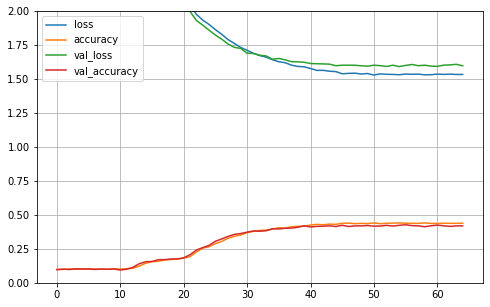

In [10]:
keras_plotter(history)

In [11]:
import numpy as np
y_pred=model1.predict(x_train)
y_pred_sparse=np.argmax(y_pred,axis=1)
y_train_sparse=np.argmax(y_train,axis=1)
from sklearn.metrics import accuracy_score
acc=accuracy_score(y_train_sparse,y_pred_sparse)
print("Train Accuracy",acc)

Train Accuracy 0.468725


In [12]:
import numpy as np
y_pred=model1.predict(x_val)
y_pred_sparse=np.argmax(y_pred,axis=1)
y_val_sparse=np.argmax(y_val,axis=1)
from sklearn.metrics import accuracy_score
acc=accuracy_score(y_val_sparse,y_pred_sparse)
print("Validation Loss",acc)

Validation Loss 0.4193


In [13]:
import numpy as np
y_pred=model1.predict(x_test)
y_pred_sparse=np.argmax(y_pred,axis=1)
y_test_sparse=np.argmax(y_test,axis=1)
from sklearn.metrics import accuracy_score
acc=accuracy_score(y_test_sparse,y_pred_sparse)
print("Test Accuracy",acc)

Test Accuracy 0.421


In [14]:
def mc_droupout(model1,x_test,y_test):
    
    num_iter=100
    print("test")
    y_prob_pred_temp=np.zeros((10000,10,num_iter))

    for i in range(num_iter):

        y_prob_pred_temp[:,:,i]=model1.predict(x_test)

    y_prob_pred=y_prob_pred_temp.mean(axis=2)
    y_prob_pred_sparse=np.argmax(y_prob_pred,axis=1)
    return y_prob_pred_sparse

y_prob_pred_sparse=mc_droupout(model1,x_test,y_test)
y_test_sparse=np.argmax(y_test,axis=1)
    
from sklearn.metrics import accuracy_score
acc=accuracy_score(y_test_sparse,y_prob_pred_sparse)
print("MC Dropout Test Loss",acc)


test
MC Dropout Test Loss 0.4608
